# Loop Detection using TensorFlow Object Detection API

This notebook is adapted from the [Eager Few Shot Object Detection Colab](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb), which demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint. I expanded it to a 3-class object detection proof of concept.

In [1]:
# Versions
import sys
import tensorflow as tf
print("Python version:", sys.version) 
print("TensorFlow version: ", tf.__version__)

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
TensorFlow version:  2.4.0


In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import numpy as np
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Utilities

In [3]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

## Loop data

In [4]:
# The loop images were downloaded from GCP (gs://bl831_loop_detection_data)
image_dir = 'bl831_loop_detection_data/gcp_training_images/images'

# Load the first 200 images as the training dataset
num_train = 200
train_images_np = []
for i in range(num_train):    
  image_path = os.path.join(image_dir, str(i).rjust(4, '0') + '.jpg')
  # each element is a uint8 numpy array with shape (704, 480, 3)
  train_images_np.append(load_image_into_numpy_array(image_path))

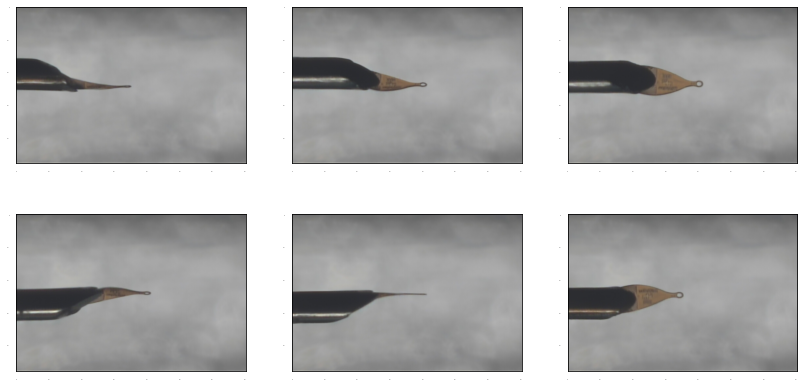

In [5]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# Plot first 6 images
for idx, train_image_np in enumerate(train_images_np[:6]):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [6]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
num_classes = 3
nylon_class_id = 1
mitegen_class_id = 2
pin_class_id = 3

category_index = {nylon_class_id: {'id': nylon_class_id, 'name': 'nylon'},
                  mitegen_class_id: {'id': mitegen_class_id, 'name': 'mitegen'},
                  pin_class_id: {'id': pin_class_id, 'name': 'pin'}}

category_index

{1: {'id': 1, 'name': 'nylon'},
 2: {'id': 2, 'name': 'mitegen'},
 3: {'id': 3, 'name': 'pin'}}

In [7]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1

train_image_tensors = []

for train_image_np in train_images_np:
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))

In [8]:
# label file
label_csv = 'bl831_loop_detection_data/train-11-19-2020.csv'

# Note label was missing in one line! 
# UNASSIGNED,gs://bl831_loop_detection_data/gcp_training_images/images/0030.jpg, ,0.4446,0.5083,,,0.5043,0.575,,
# Correct version:
# UNASSIGNED,gs://bl831_loop_detection_data/gcp_training_images/images/0030.jpg,mitegen,0.4446,0.5083,,,0.5043,0.575,,

gt_boxes = []
groundtruth_classes = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

# very ugly code!
with open(label_csv) as f:
    for line in f:
        label = line.split(',')
        fname=label[1][-8:]
        i = int(fname.split('.')[0])
        if i >= num_train:
            break
        if len(gt_boxes) < i+1:
            gt_boxes.append([])
            groundtruth_classes.append([])            
        # Note the order!!!
        gt_boxes[i].append([float(label[4]), float(label[3]), float(label[8]), float(label[7])])
        if label[2] == 'nylon':
            groundtruth_classes[i].append(nylon_class_id)
        if label[2] == 'mitegen':
            groundtruth_classes[i].append(mitegen_class_id)
        if label[2] == 'pin':
            groundtruth_classes[i].append(pin_class_id)
            
for gt_box in gt_boxes:
    gt_box_tensors.append(tf.convert_to_tensor(gt_box, dtype=tf.float32))

for g in groundtruth_classes:
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(g, dtype=tf.int32) - label_id_offset
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')
print(gt_classes_one_hot_tensors[0])
print(gt_box_tensors[0])

Done prepping data.
tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[0.3312 0.     0.5375 0.2685]
 [0.5021 0.4517 0.525  0.5043]], shape=(2, 4), dtype=float32)


### Sanity Check!

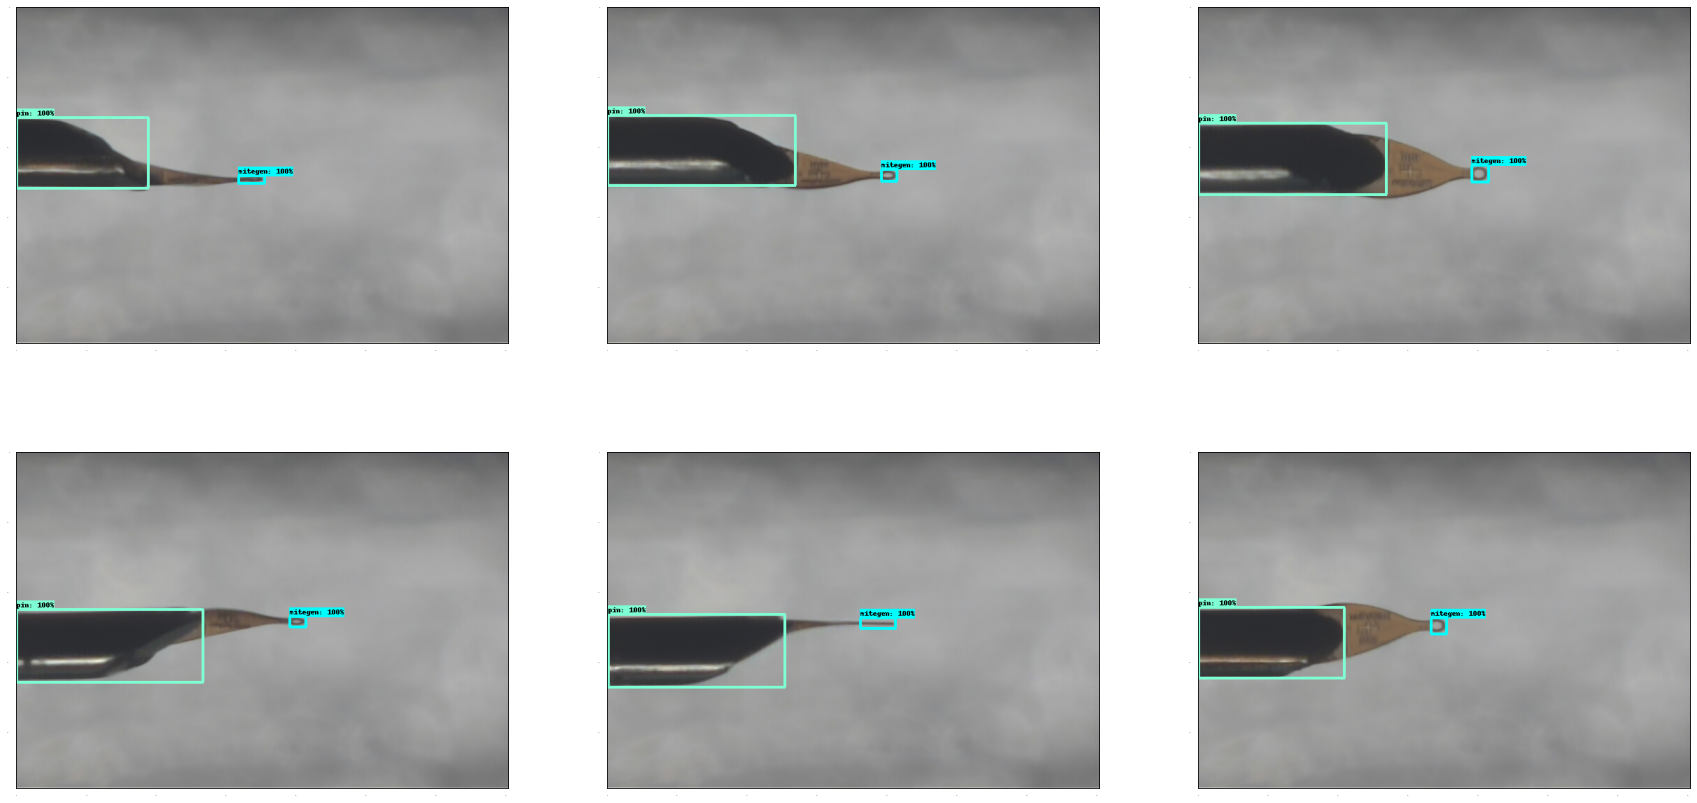

In [9]:
dummy_scores = np.array([1.0, 1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      np.array(gt_boxes[idx], dtype=np.float32),
      np.array(groundtruth_classes[idx], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

## Create model and restore weights for all but last layer

In [10]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 3
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [11]:
# Deprecated?
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 25
learning_rate = 0.01
num_batches = 500

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/opt/miniconda3/envs/tf2/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 500, loss=1.5084505
batch 10 of 500, loss=0.52182454
batch 20 of 500, loss=0.40571585
batch 30 of 500, loss=0.37442756
batch 40 of 500, loss=0.24283099
batch 50 of 500, loss=0.28395572
batch 60 of 500, loss=0.31389046
batch 70 of 500, loss=0.26816767
batch 80 of 500, loss=0.20233002
batch 90 of 500, loss=0.29989904
batch 100 of 500, loss=0.20075741
batch 110 of 500, loss=0.19482476
batch 120 of 500, loss=0.16394788
batch 130 of 500, loss=0.16792229
batch 140 of 500, loss=0.1625185
batch 150 of 500, loss=0.16922855
batch 160 of 500, loss=0.1565148
batch 170 of 500, loss=0.13204935
batch 180 of 500, loss=0.13483897
batch 190 of 500, loss=0.17951137
batch 200 of 500, loss=0.13815075
batch 210 of 500, loss=0.1305258
batch 220 of 500, loss=0.12064375
batch 230 of 500, loss=0.2376084
batch 240 of 500, loss=0.17254904
batch 250 of 500, loss=0.23171309
batch 260 of 500, loss=0.11680413
batch 270 of 500, loss=0.12244438
batch 280 of 500, loss=0.13015026
batch 290 of 500, loss=0.15942

## Load test images and run inference with new model!

In [16]:
test_image_dir = 'bl831_loop_detection_data/gcp_training_images/images'
test_images_np = []

for i in range(200, 250):
  image_path = os.path.join(test_image_dir, str(i).rjust(4, '0') + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name=('%04d' % (i+200)) + "-bbox" + ".jpg" )

## Comments

* It's not perfect yet. But looks like it can be improved to yield better results
* Once a good model is trained. It can then be saved for inferences.
* Here we explicitly write Python code. Another approach is what is outlined in [How to train your own Object Detector with TensorFlow’s Object Detector API](https://towardsdatascience.com/how-to-train-your-own-object-detector-with-tensorflows-object-detector-api-bec72ecfe1d9)
* A much detailed tutorial is at <https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/index.html>
* [Tensorflow object detection config files documentation](https://stackoverflow.com/questions/49148962/tensorflow-object-detection-config-files-documentation)
* [How to Train Your Own Object Detector Using TensorFlow Object Detection API](https://neptune.ai/blog/how-to-train-your-own-object-detector-using-tensorflow-object-detection-api)
* [3 steps to update parameters of Faster R-CNN/SSD models in TensorFlow Object Detection API](https://towardsdatascience.com/3-steps-to-update-parameters-of-faster-r-cnn-ssd-models-in-tensorflow-object-detection-api-7eddb11273ed)